In [41]:

from IPython.display import clear_output
#from ipywidgets import interact, IntSlider

import os, os.path, shutil
import zipfile
import random
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import music21
import pypianoroll
import pretty_midi
import seaborn as sns

from pypianoroll import Multitrack, Track
from tqdm import tqdm
from music21 import *
from typing import Tuple
from torch import Tensor
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset
from collections import Counter


#import itertools
#import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import moviepy.editor as mpy
#import music21
#from IPython import display
#import seaborn as sns

Paths to Directories

In [42]:
root_dir = './'

#Directory to save model data
model_dir = os.path.join(root_dir, 'model')

#Directory to the JSB dataset used to train and evaluate the model
dataset_dir = os.path.join(root_dir, 'Dataset/Jsb16thSeparated.npz')

dataset_eval_midi = os.path.join(root_dir, 'Dataset/eval/bevmidi')

#Directory to the alternate dataset used to draw inference from the Mahalanobis distance evaluation
mEval_altDataset = os.path.join(root_dir, 'Dataset/eval/revmidi')

#Directory to save midi files during training
train_out_dir = os.path.join(model_dir, 'train_out/midi')

#Directory to save pianoroll images during training
train_out_dir_p = os.path.join(model_dir, 'train_out/pianorolls')

#Directory to save midi files during inference
test_out_dir = os.path.join(model_dir, 'test_out/midi')

#Directory to save pianoroll and score images during inference
test_out_dir_p = os.path.join(model_dir, 'test_out/rollsandscores')


os.makedirs(train_out_dir, exist_ok=True)
os.makedirs(train_out_dir_p, exist_ok=True)
os.makedirs(test_out_dir, exist_ok=True)
os.makedirs(test_out_dir_p, exist_ok=True)

In [43]:
# Data
n_tracks = 4  # number of tracks
n_pitches = 83  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 2  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 0, 0]  # program number for each track
is_drums = [False, False, False, False]  # drum indicator for each track
track_names = ['Soprano', 'Alto', 'Tenor', 'Bass']  # name of each track
tempo = 100

measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)

# Training
batch_size = 64
latent_dim = 128
n_steps = 7000

# Sampling
sample_interval = 10  # interval to run the sampler (in step)
n_samples = 4

#Directories
!mkdir midiDataset

A subdirectory or file midiDataset already exists.


In [4]:
"""Midi dataset."""

class MidiDataset(Dataset):
    """MidiDataset.
    Parameters
    ----------
    path: str
        Path to dataset.
    split: str, optional (default="train")
        Split of dataset.
    n_bars: int, optional (default=2)
        Number of bars.
    n_steps_per_bar: int, optional (default=16)
        Number of steps per bar.
    """

    def __init__(
        self,
        path: str,
        split: str = "train",
        n_bars: int = 8,
        n_steps_per_bar: int = 16,
    ) -> None:
        """Initialize."""
        self.n_bars = n_bars
        self.n_steps_per_bar = n_steps_per_bar
        dataset = np.load(path, allow_pickle=True, encoding="bytes")[split]
        self.data_binary, self.data_ints, self.data = self.__preprocess__(dataset)

    def __len__(self) -> int:
        """Return the number of samples in dataset."""
        return len(self.data_binary)

    def __getitem__(self, index: int) -> Tensor:
        """Return one samples from dataset.
        Parameters
        ----------
        index: int
            Index of sample.
        Returns
        -------
        Tensor:
            Sample.
        """
        return torch.from_numpy(self.data_binary[index]).float()

    def __preprocess__(self, data: np.ndarray) -> Tuple[np.ndarray]:
        """Preprocess data.
        Parameters
        ----------
        data: np.ndarray
            Data.
        Returns
        -------
        Tuple[np.ndarray]:
            Data binary, data ints, preprocessed data.
        """
        data_ints = []
        for x in data:
            skip = True
            skip_rows = 0
            while skip:
                if not np.any(np.isnan(x[skip_rows: skip_rows + 4])):
                    skip = False
                else:
                    skip_rows += 4
            #print(x.shape)
            if self.n_bars * self.n_steps_per_bar < x.shape[0]:
                data_ints.append(x[skip_rows: self.n_bars * self.n_steps_per_bar + skip_rows, :])
        
        data_ints = np.array(data_ints)

        #print(data_ints.shape)
        self.n_songs = data_ints.shape[0]
        self.n_tracks = data_ints.shape[2]
        data_ints = data_ints.reshape([self.n_songs, self.n_bars * self.n_steps_per_bar, self.n_tracks])
        #print(data_ints.shape)
        max_note = n_pitches
        mask = np.isnan(data_ints)
        data_ints[mask] = max_note + 1
        max_note = max_note + 1
        data_ints = data_ints.astype(int)
        #print(data_ints.shape)
        
        num_classes = max_note + 1
        data_binary = np.eye(num_classes)[data_ints]
        data_binary[data_binary == 0] = -1
        data_binary = np.delete(data_binary, max_note, -1)
        data_binary = data_binary.transpose([0, 1, 3, 2])
        #print(data_binary.shape)
        return data_binary, data_ints, data

In [5]:
from pypianoroll.track import BinaryTrack
def save_pianoroll_as_midi(dataset,
                  programs=programs,
                  track_names=track_names,
                  is_drums=is_drums,
                  tempo=tempo,           # in bpm
                  beat_resolution=beat_resolution,  # number of time steps
                  destination_path="/content/midiDataset/"
                  ):
    data_ = []
    sopData = []

    for piece in dataset:

      pianoroll = piece > 0

      #print(pianoroll.shape)

    # Reshape batched pianoroll array to a single pianoroll array
      pianoroll_ = pianoroll.reshape((-1, pianoroll.shape[1], pianoroll.shape[2]))

      #print(pianoroll_.shape)

    # Create the tracks   
      tracks = []
      for idx in range(pianoroll_.shape[2]):
          tracks.append(pypianoroll.BinaryTrack(
            track_names[idx], programs[idx], is_drums[idx], pianoroll_[..., idx]))
          
      multitrack = pypianoroll.Multitrack(
          tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
      
      data_.append(multitrack)

      melody = []
      for idx in range(1):
        melody.append(pypianoroll.BinaryTrack(
            track_names[idx], programs[idx], is_drums[idx], pianoroll_[..., idx]))
        
        sMultitrack = pypianoroll.Multitrack(
          tracks=melody, tempo=tempo_array, resolution=beat_resolution)
        
        sopData.append(sMultitrack)
        
    
    data_[0].write('./midiDataset/test.mid')
    print('Midi saved to ', destination_path)
    print(tracks)

    return data_, sopData

Dataset Preprocessing and Organisation

In [73]:
from torch.utils import data
from numpy.core.fromnumeric import shape

train = MidiDataset(dataset_dir).data_binary
test = MidiDataset(dataset_dir, split='test').data_binary
valid = MidiDataset(dataset_dir, split='valid').data_binary
ev = np.concatenate([train, test])

print(test[0].shape)

mEvalData = save_pianoroll_as_midi(ev)[0]

i = 0
for p in mEvalData:

    p.write(os.path.join(dataset_eval_midi, 'bevmidi%s.mid' % i))
    i = i+1

d = pypianoroll.read(r"D:\Github\HonoursProject-reharmonisationGAN\Dataset\eval\bevmidi\bevmidi288.mid")

f = d.stack()

print(f.shape)
data, sData = save_pianoroll_as_midi(train)

vData, sVData = save_pianoroll_as_midi(valid)

testData, sTestData = save_pianoroll_as_midi(test)



(128, 84, 4)
Midi saved to  /content/midiDataset/
[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool))]
(4, 768, 128)
Midi saved to  /content/midiDataset/
[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Alto', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Tenor', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool)), BinaryTrack(name='Bass', program=0, is_drum=False, pianoroll=array(shape=(128, 84), dtype=bool))]
Midi saved to  /content/midiDataset/
[BinaryTrack(name='Soprano', program=0, is_drum=False, pianoroll=arr

SAMPLE COLLECTION

In [9]:
def Get_Samples(data: list):

  dataS = []
  for multitrack in tqdm(data):
    
    multitrack.binarize()
      # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
      # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    
      # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + (n_pitches + 1)] 
    #print(pianoroll.shape) 
      # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    stepsPerSample = n_measures * measure_resolution
      # Randomly select a number of phrases from the multitrack pianoroll
    for i in range(0, multitrack.get_max_length(), stepsPerSample):

      if (pianoroll.sum(axis=(1, 2)) < 10).any():
          continue
    
      dataS.append(pianoroll[:, i:i + stepsPerSample])
  # Stack all the collected pianoroll segments into one big array
  #random.shuffle(dataS)
  dataS = np.stack(dataS)
  print(f"Successfully collect {len(dataS)} samples from {len(data)} songs")
  print(f"Data shape : {dataS.shape}")
  print(dataS.shape)

  return dataS

dataT = Get_Samples(data)
dataS = Get_Samples(sData)
dataVS = Get_Samples(sVData)

100%|██████████| 228/228 [00:00<00:00, 1156.51it/s]


Successfully collect 912 samples from 228 songs
Data shape : (912, 4, 32, 84)
(912, 4, 32, 84)


100%|██████████| 228/228 [00:00<00:00, 4195.87it/s]


Successfully collect 912 samples from 228 songs
Data shape : (912, 1, 32, 84)
(912, 1, 32, 84)


100%|██████████| 75/75 [00:00<00:00, 4122.46it/s]

Successfully collect 300 samples from 75 songs
Data shape : (300, 1, 32, 84)
(300, 1, 32, 84)


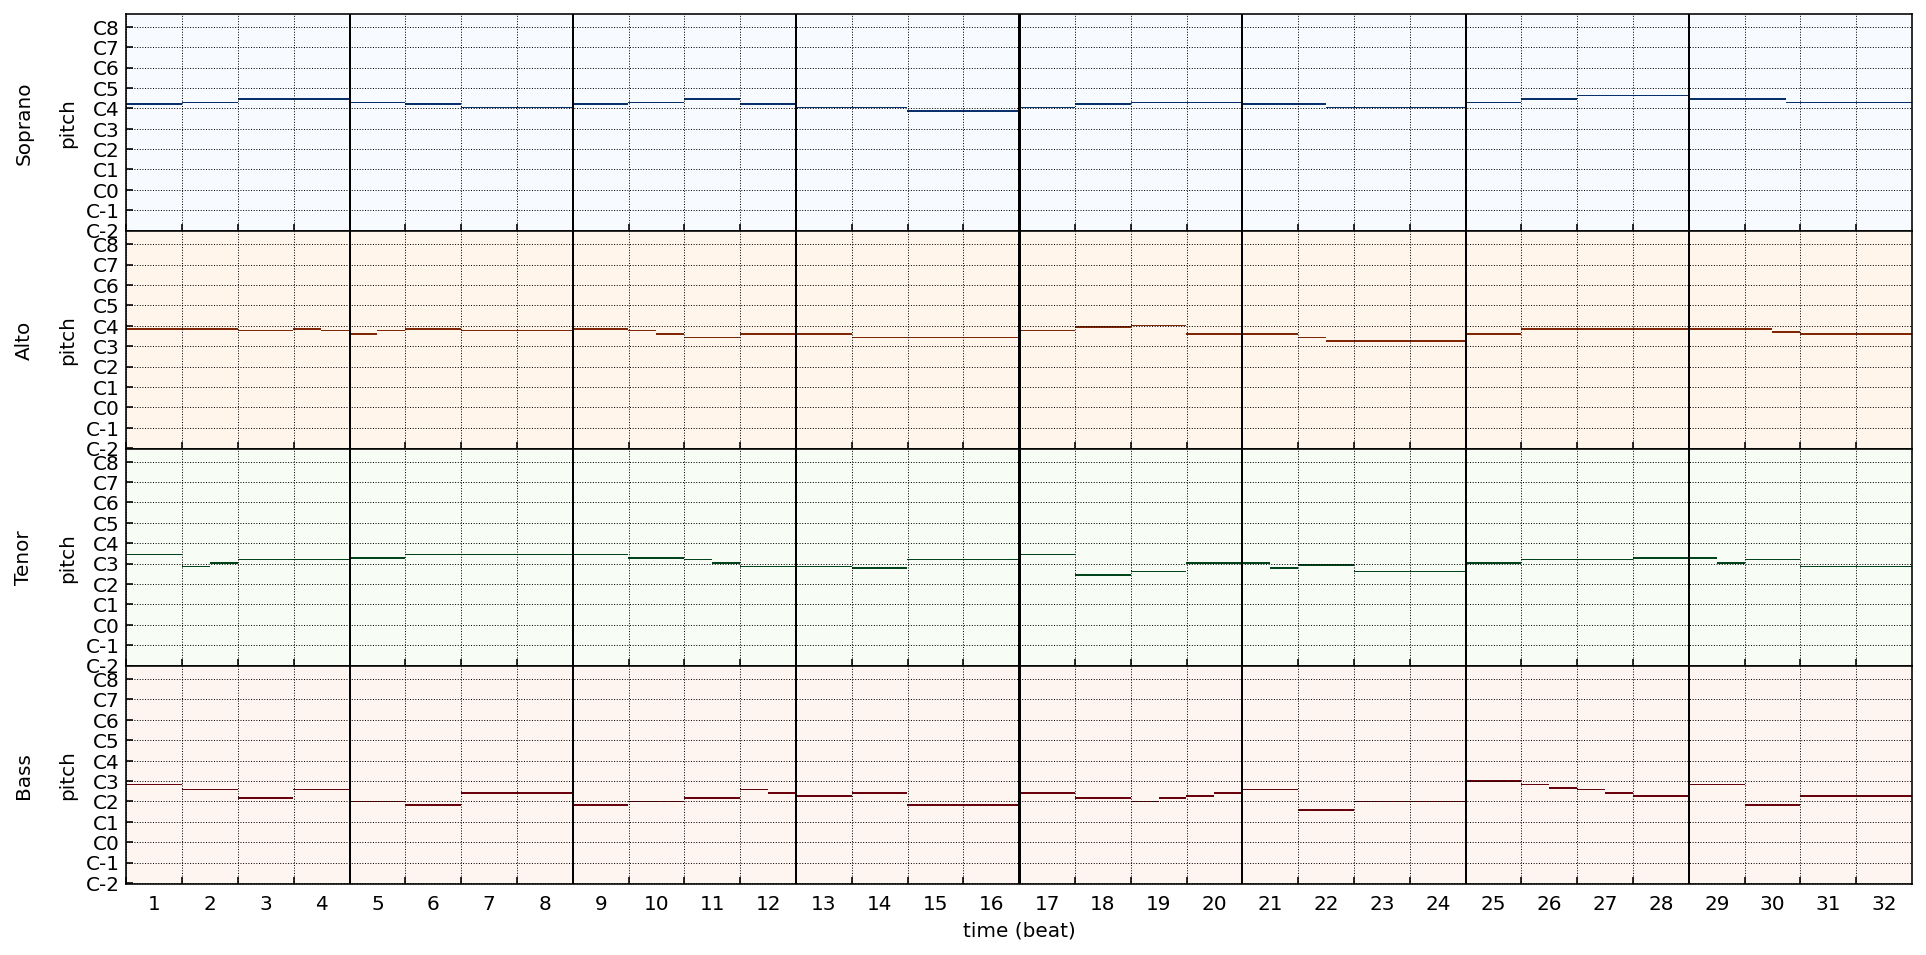

In [9]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(dataT[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches + 1) ))) #
    tracks.append(pypianoroll.BinaryTrack(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
multitrack.write('./midiDataset/test3.mid')
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 2 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [10]:
dataT = torch.as_tensor(dataT, dtype=torch.float32)
dataS = torch.as_tensor(dataS, dtype=torch.float32)
dataVS = torch.as_tensor(dataVS, dtype=torch.float32)

dataset_ = torch.utils.data.TensorDataset(dataT, dataS)
datasetV_ = torch.utils.data.TensorDataset(dataVS)

data_loader = torch.utils.data.DataLoader(
    dataset_, batch_size=batch_size, drop_last=True, shuffle=True)
data_loader_V = torch.utils.data.DataLoader(
    datasetV_, batch_size=4, drop_last=True, shuffle=False)

MODEL

In [11]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride, conditioned=False):
        super().__init__()

        if conditioned == False:
            self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
            self.batchnorm = torch.nn.BatchNorm3d(out_dim)

        else:
            self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
            self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [12]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneratorBlock(1, 16, (2, 1, 1), (2, 1, 1))
        self.transconv1 = GeneratorBlock(16, 32, (1, 4, 4), (1, 4, 4))
        self.transconv2 = GeneratorBlock(32, 64, (1, 2, 7), (1, 2, 7))
        self.transconv3 = GeneratorBlock(64, 128, (1, 2, 3), (1, 2, 3))
        self.transconv4 = torch.nn.ModuleList([
            GeneratorBlock(256, 64, (2, 4, 14), (2, 4, 14), conditioned=True)
            for _ in range(n_tracks - 1)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneratorBlock(64, 1, (1, 4, 6), (1, 4, 6), conditioned=True)
            for _ in range(n_tracks - 1)
        ])

    def forward(self, z, y):    
      z = z.view(-1, latent_dim, 1, 1, 1)
      y = y.view(-1, 1, n_measures, measure_resolution, (n_pitches + 1))
      x = self.transconv0(y)
      x = self.transconv1(x)
      x = self.transconv2(x)
      x = self.transconv3(x)
      x = torch.cat((x, z), dim=1)
      x = [transconv(x) for transconv in self.transconv4]
      x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
      x = torch.cat((y, x), dim=1)
      x = x.view(-1, n_tracks, n_measures * measure_resolution, (n_pitches + 1))

      return x

In [13]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [14]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [15]:
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16 * 4, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (1, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x, y):
        x = x.view(-1, n_tracks, n_measures, measure_resolution, (n_pitches + 1))
        y = y.view(-1, 1, n_measures, measure_resolution, (n_pitches + 1))
        x = torch.cat((x, y), dim=1)
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

In [16]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1)#.cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates, labels)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1)#.cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [17]:
def train_one_step(d_optimizer, g_optimizer, real_samples, labels):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    #print(latent.shape)

    # Transfer data to GPU
    #if torch.cuda.is_available():
    real_samples = real_samples#.cuda()
    latent = latent#.cuda()

    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples, labels)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent, labels)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach(), labels)
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data, labels.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples, labels)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

In [18]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
#if torch.cuda.is_available():
discriminator = discriminator#.cuda()
generator = generator#.cuda()
sample_latent = sample_latent#.cuda()

# Create an empty dictionary to store history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Number of parameters in G: 5596985
Number of parameters in D: 134401


TRAINING

In [151]:
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

d_losses = []
g_losses = []

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples, labels in data_loader:
        #for labels in data_loader_S:
            #print(data)
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples, labels)

        d_loss = d_loss.detach().numpy()
        g_loss = g_loss.detach().numpy()

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'negative_critic_loss': -running_d_loss})
    # liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
    
    # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
    
        if step % sample_interval == 0:

            d_losses.append(d_loss)
            g_losses.append(g_loss)
        # Get generated samples
            random_idx = np.random.choice(len(dataVS), n_samples, replace=False)
            vLabels = dataVS[0:4]
            generator.eval()
            samples = generator(sample_latent, vLabels).cpu().detach().numpy()
            history_samples[step] = samples

            #Display loss curves
            #clear_output(True)
            #if step > 0:
              #liveloss.send()
        
            
        
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

# Display generated samples
samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, (n_pitches+1))
tracks = []
for idx, (program, is_drum, track_name) in enumerate(
    zip(programs, is_drums, track_names)
):
    pianoroll = np.pad(
        samples[idx] > 0.5,
        ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches+1)))
    )
    tracks.append(
        pypianoroll.BinaryTrack(
            name=track_name,
            program=program,
            is_drum=is_drum,
            pianoroll=pianoroll
        )
    )
m = Multitrack(
tracks=tracks,
tempo=tempo_array,
resolution=beat_resolution
)

m.write('./test.mid')
axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(
        measure_resolution,
        4 * measure_resolution * n_measures,
        measure_resolution
    ):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()


(d_loss=-2.911999, g_loss= 4.747654): 28501it [18:15:40,  2.31s/it]


ValueError: axes don't match array

PLOT LOSSES

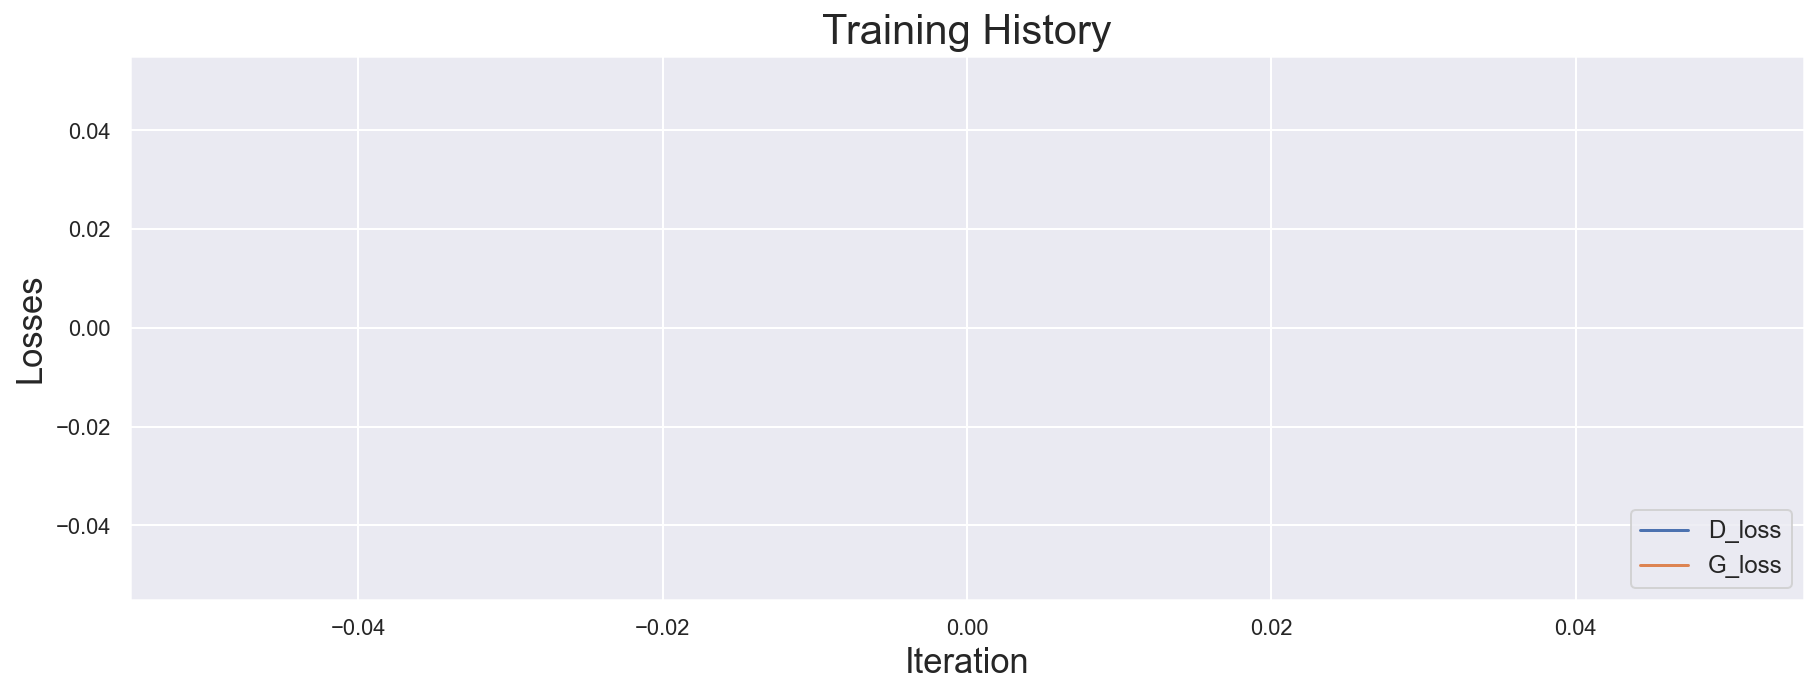

In [152]:
def plot_loss_logs(G_loss, D_loss, figSize=(15, 5), smoothing=0.001):

    plt.ion()
    sns.set()
    ax.set_ylim([-100, 100])
    plt.figure(figsize=figSize)
    plt.plot(D_loss, label='D_loss')
    plt.plot(G_loss, label='G_loss')
    plt.legend(loc='lower right', fontsize='medium')
    plt.xlabel('Iteration', fontsize='x-large')
    plt.ylabel('Losses', fontsize='x-large')
    plt.title('Training History', fontsize='xx-large')
    plt.savefig(os.path.join(train_out_dir_p, 'model_loss.png'))
    

plot_loss_logs(g_losses, d_losses, figSize=(15, 5), smoothing=0.001)

TRAINING SAMPLE HISTORY

Step=0


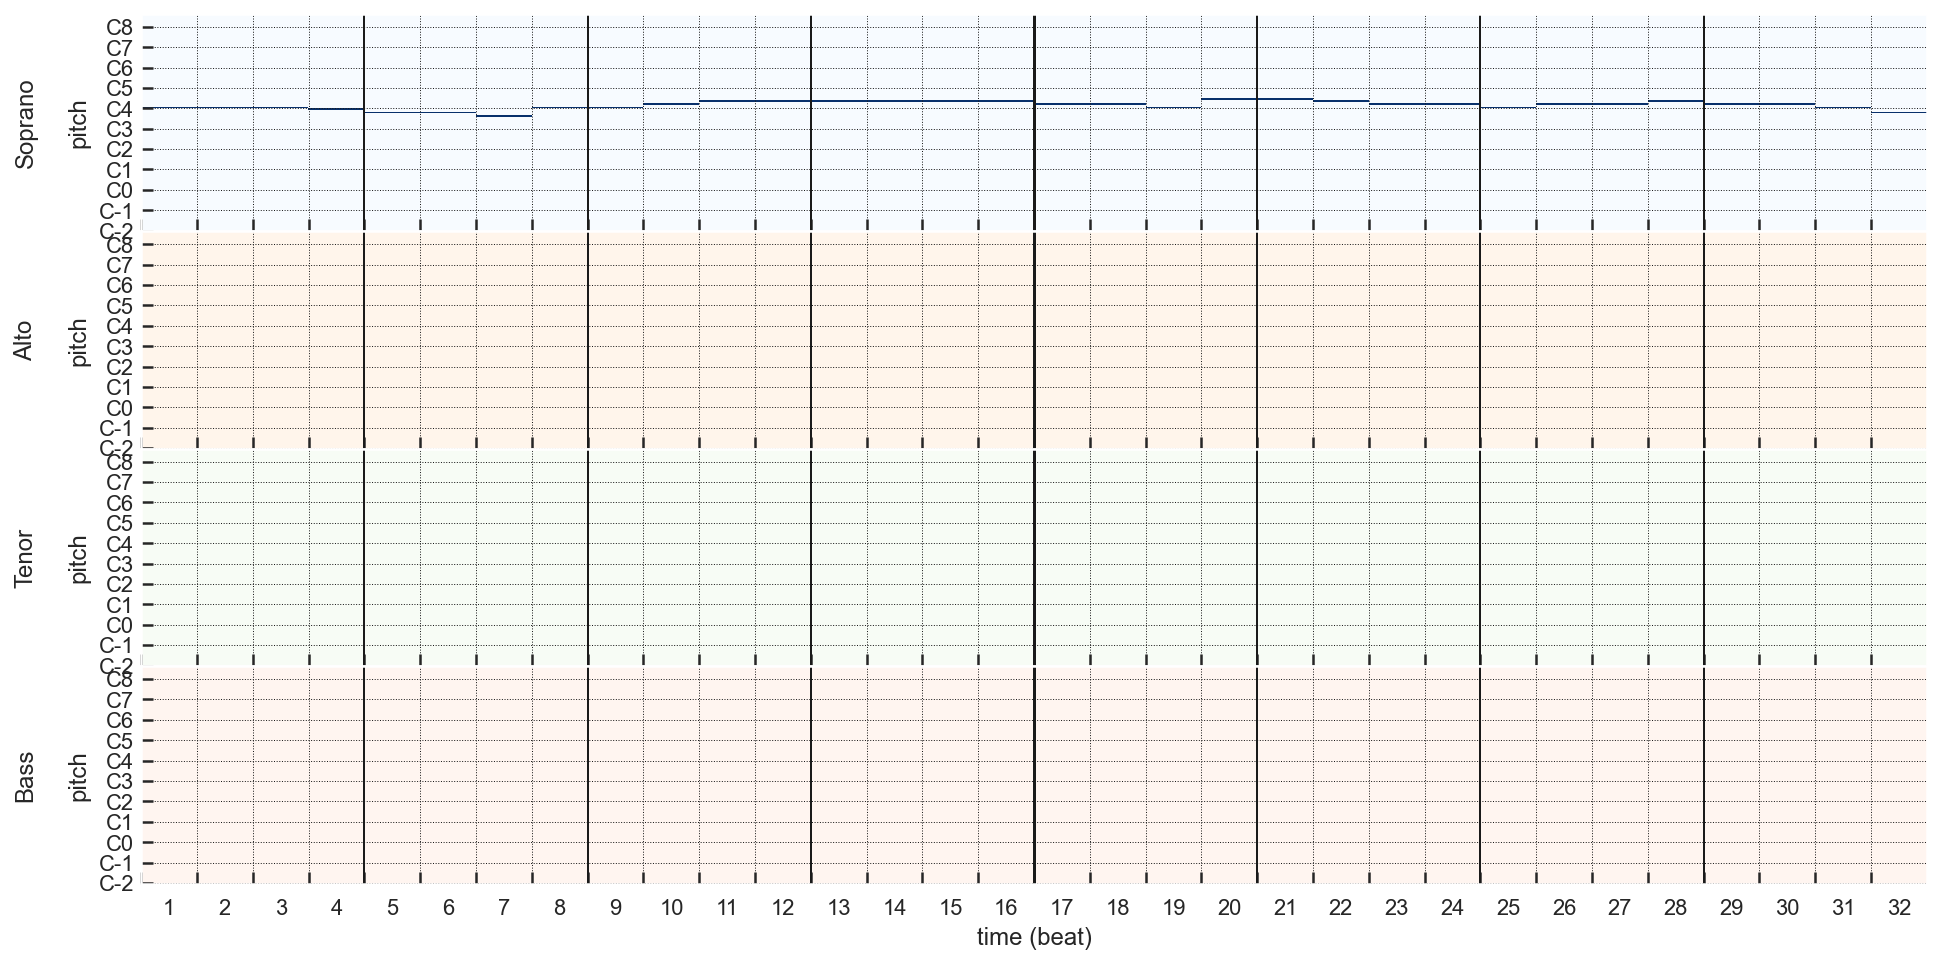

Step=10


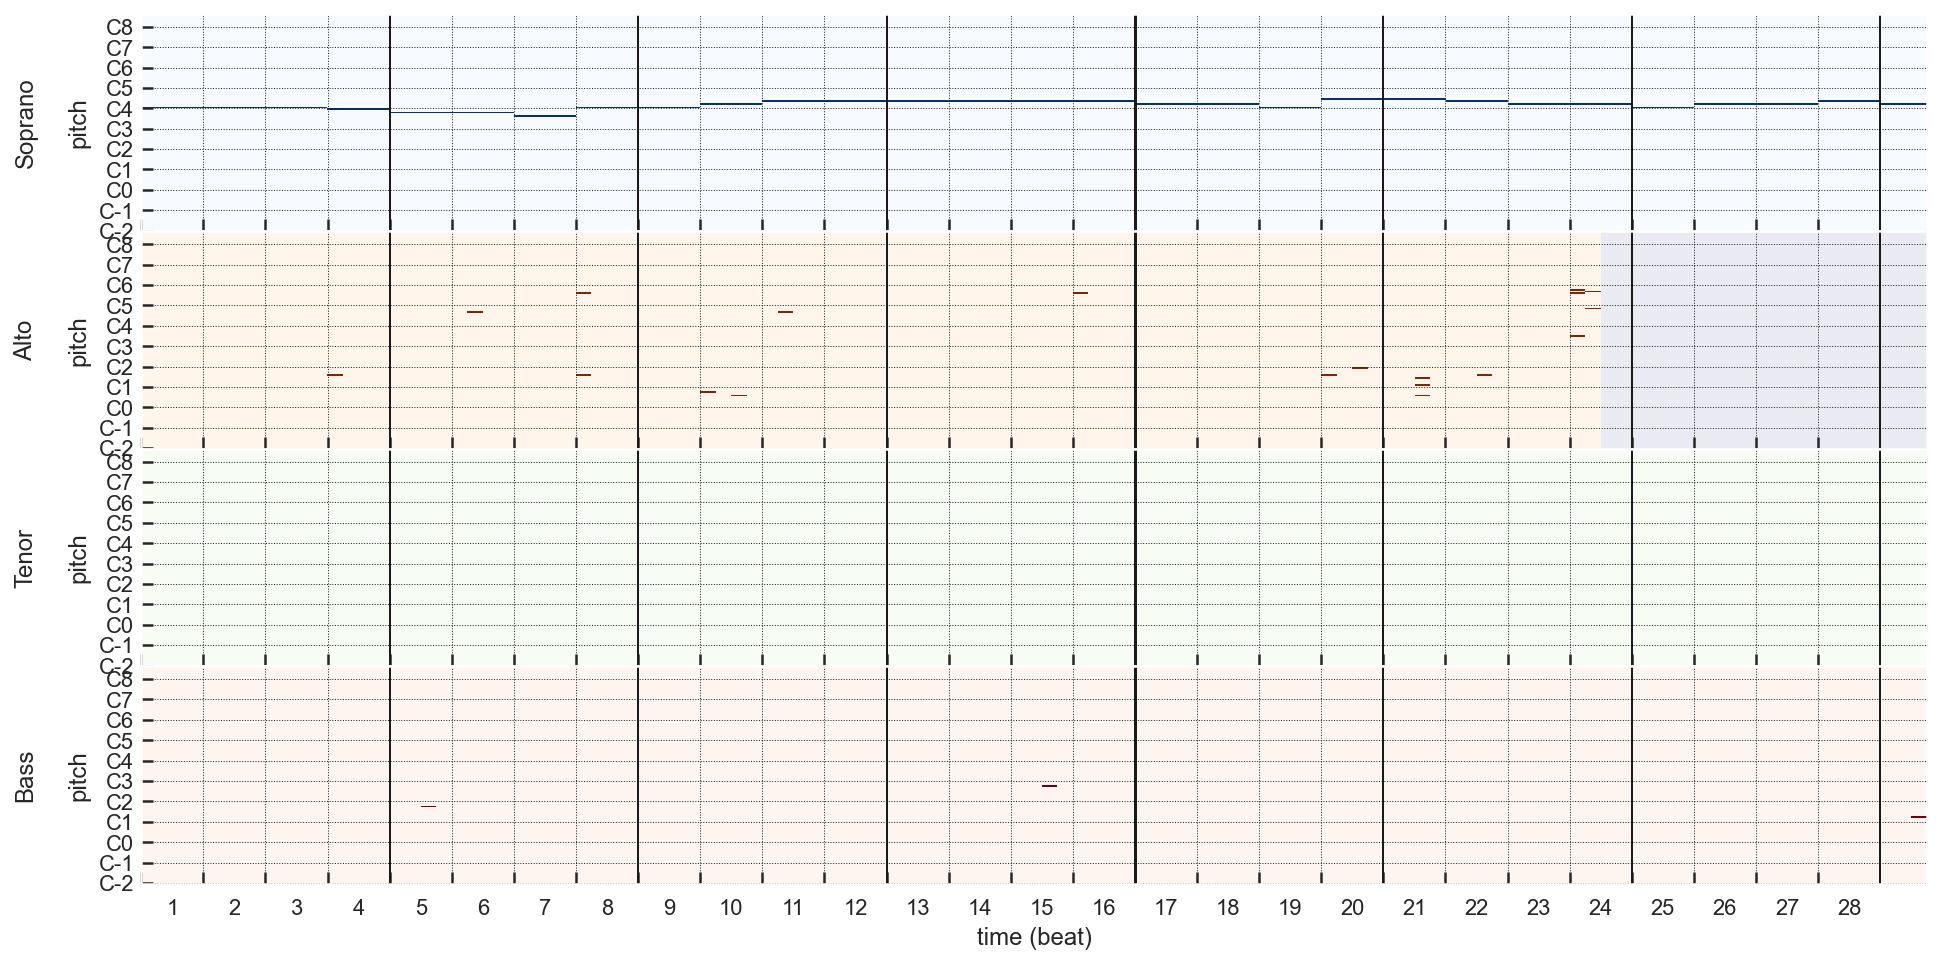

Step=100


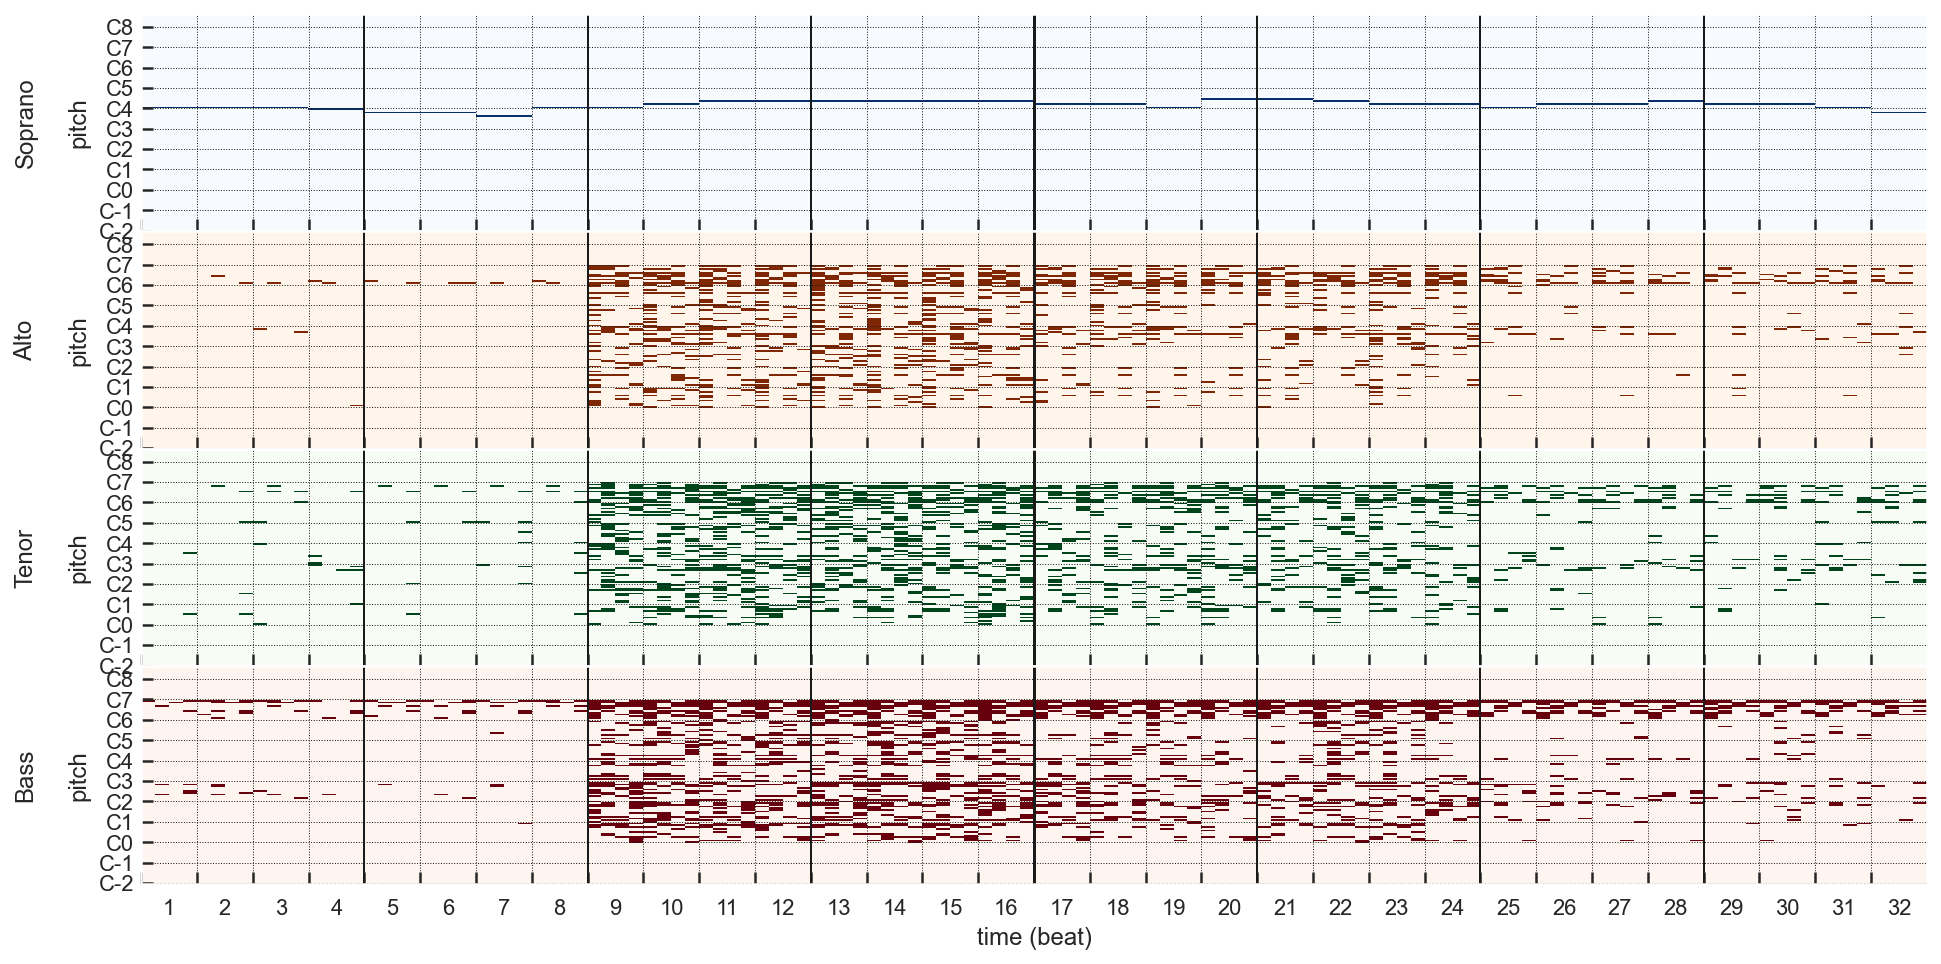

Step=1000


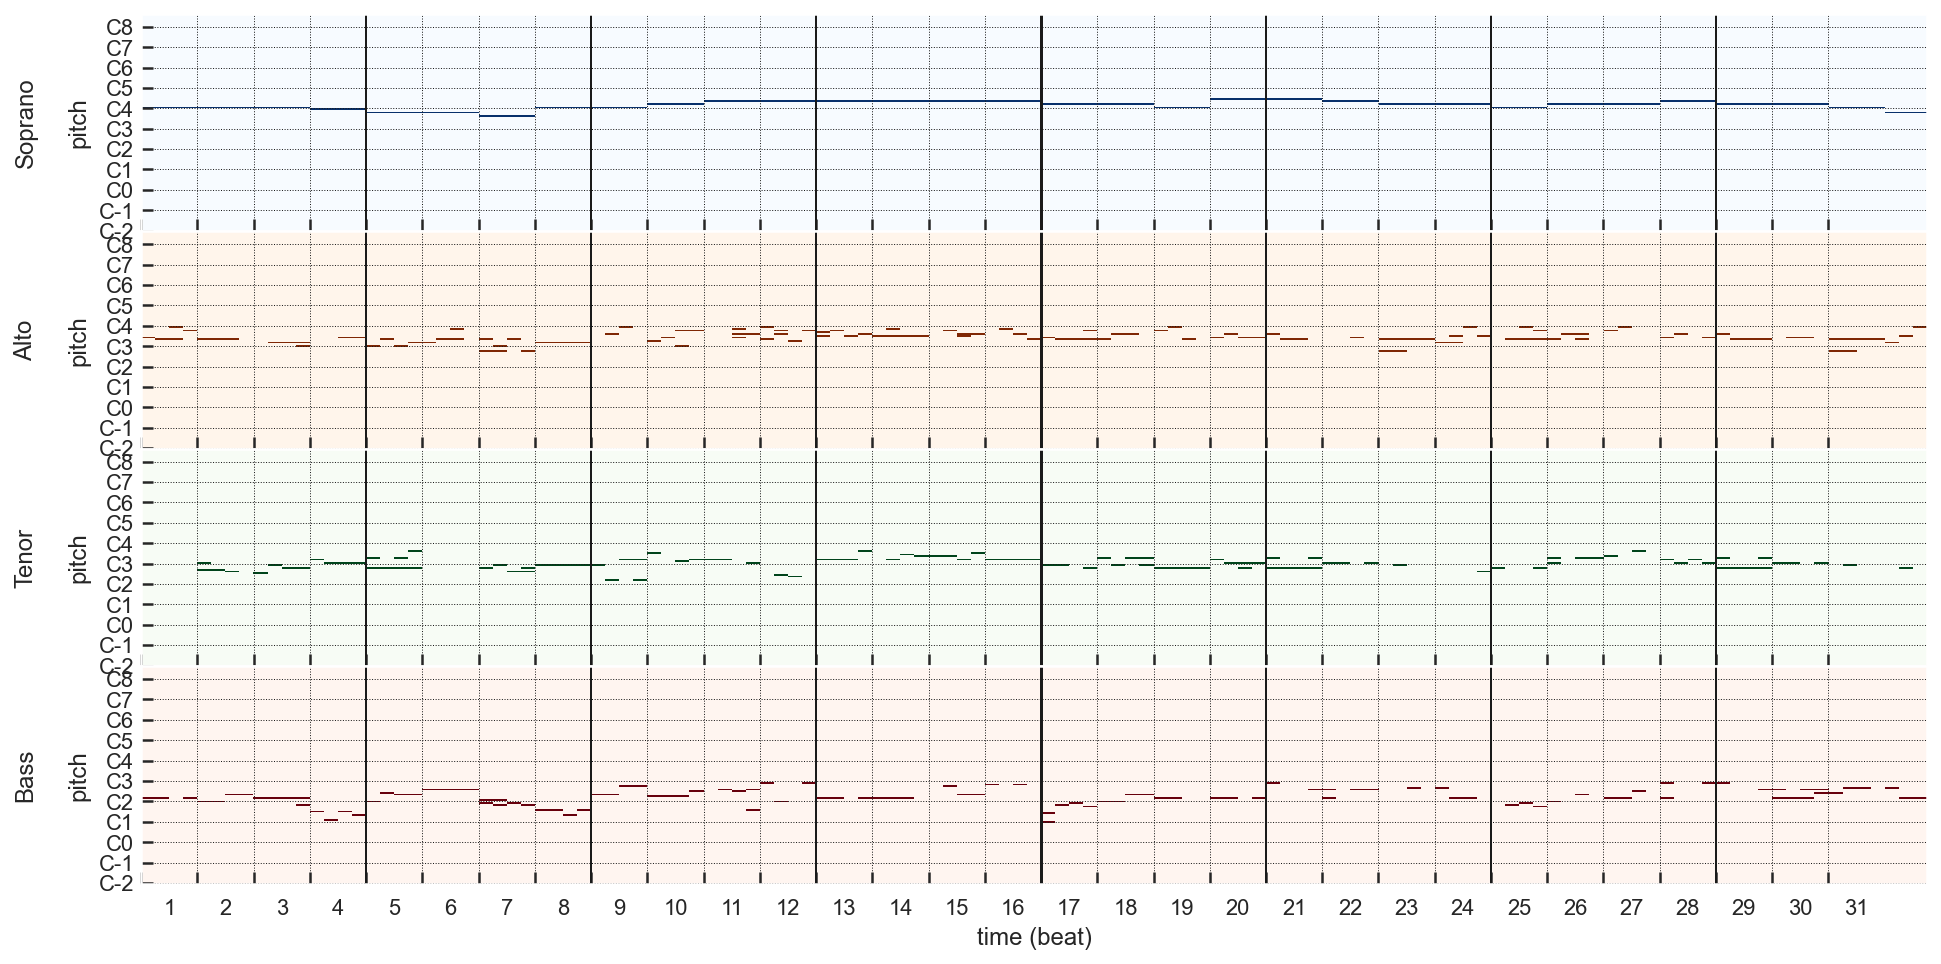

Step=28500


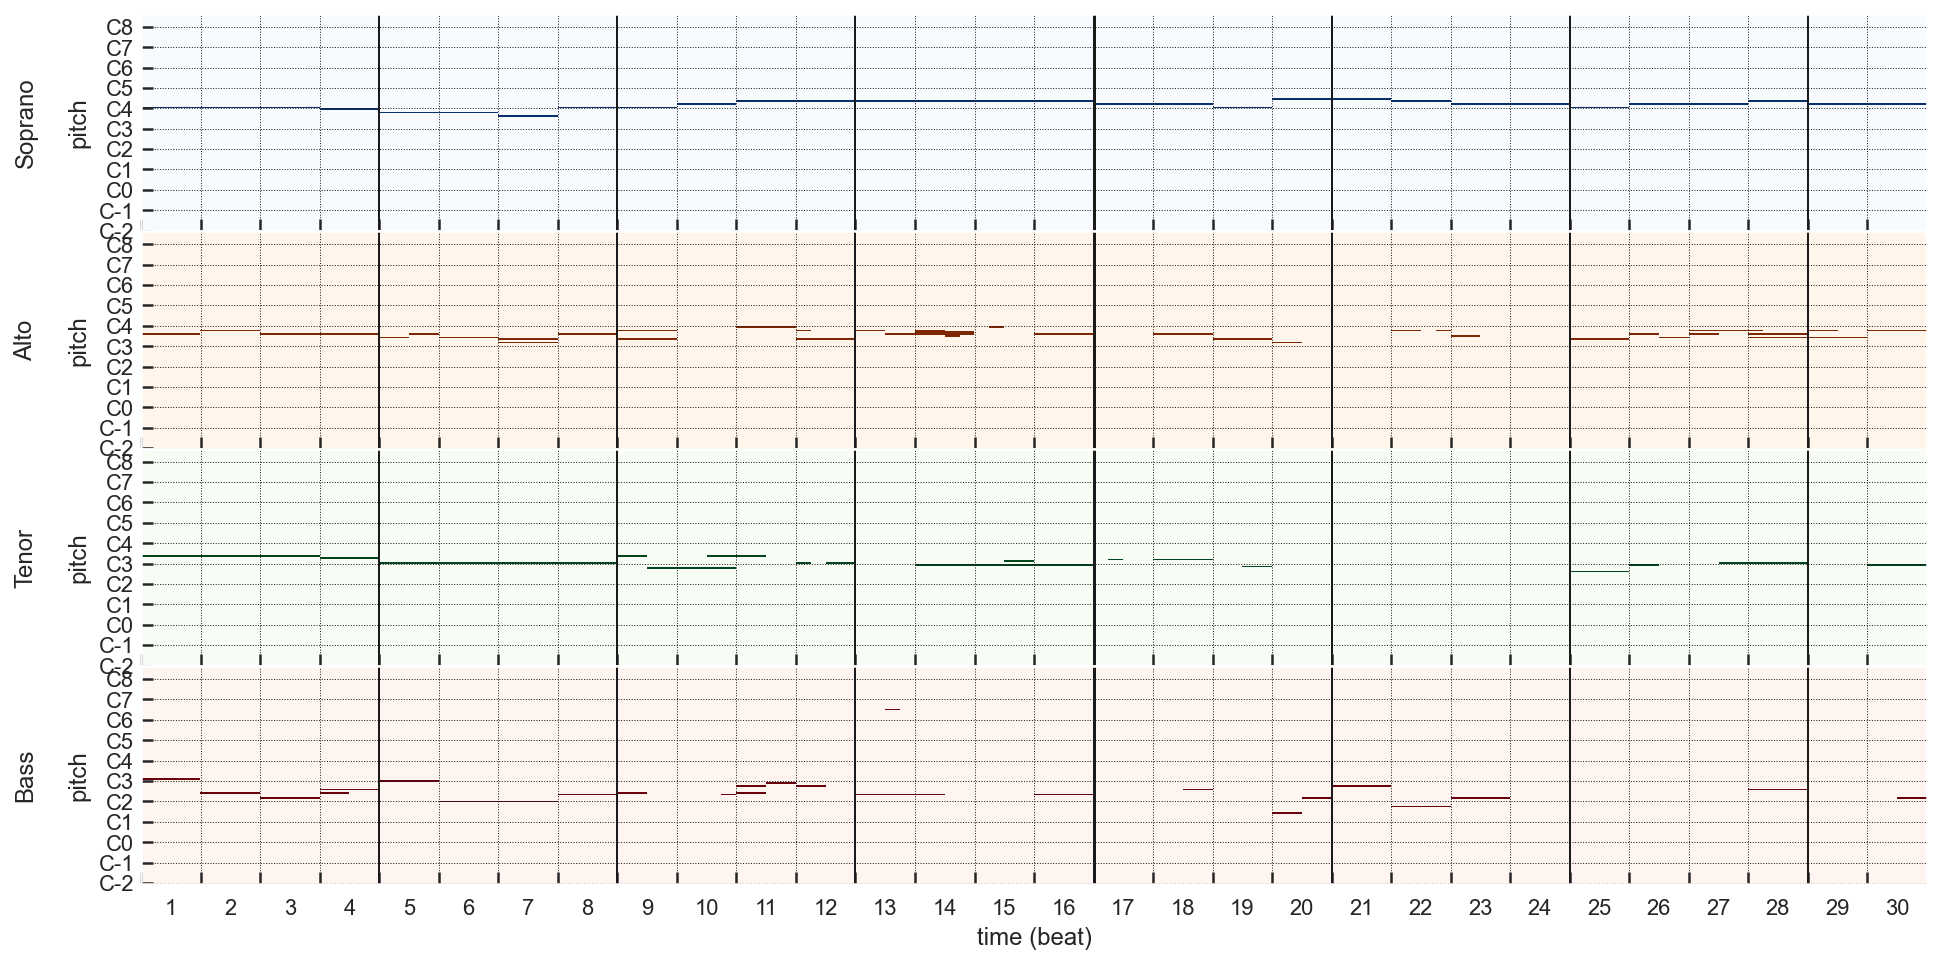

In [35]:
# Show history
steps = [0, sample_interval, 10 * sample_interval, 100 * sample_interval, n_steps]
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, (n_pitches+1))
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches+1)))
        )
        tracks.append(
            pypianoroll.BinaryTrack(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    
    m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)

    m.write(os.path.join(train_out_dir, 'midiforstep %s.mid' % step))
    
    m.binarize()
    m.set_resolution(beat_resolution)

    axs = m.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 8))
    plt.savefig(os.path.join(train_out_dir_p, 'pianorollforstep%s.png' % step))
    plt.show()


INFERENCE

In [36]:
i = 0

testPRoll = []
for v in data_loader_V:

    generator.eval()
    
    samples = generator(sample_latent, v[0]).cpu().detach().numpy()

    samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, (n_pitches+1))
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(
        zip(programs, is_drums, track_names)
    ):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches+1)))
        )
        tracks.append(
            pypianoroll.BinaryTrack(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll
            )
        )
    m = Multitrack(
    tracks=tracks,
    tempo=tempo_array,
    resolution=beat_resolution
    )

    testPRoll.append(m)

    m.write(os.path.join(test_out_dir, 'omid%s.mid' % i))
    i = i+1
    

In [ ]:
torch.save(generator, "D:\Github\outputs\potentialData1\Gen7\generator.pth")

PLOT INFERENCE LOSSES

EVALUATION

    Mahalanobis Distance:

In [37]:
class Evaluate():

    def __init__(self, path: str, piece: np.ndarray):

        self.piece = piece
        self.piece_signature_vector = []


        trk = music21.converter.parse(path)
        pieceArr, Pianoroll = self.PreProcess(piece)

        a, b, c, d = self.Pitch_Range_Descriptors(trk)

        e, f, g, h = self.Pitch_Interval_Range(trk)
        
        i, j, k, l = self.Note_Duration(trk)


        self.piece_signature_vector.extend(
            [self.Number_of_notes(trk)[1], 
            self.Occupation_Rate(Pianoroll),
            self.Polyphonic_Rate(pieceArr, trk),
            a, b, c, d,
            e, f, g, h,
            i, j, k, l
            ])
        
        

    def PreProcess(self, piece: np.ndarray):

        Pianoroll = piece.reshape(piece.shape[1], piece.shape[0], piece.shape[2])

        sop = []
        alt = []
        ten = []
        bass = []

        tPianoroll = (np.where(Pianoroll == True))

        sop = [[i] for i in tPianoroll[2][0:128]]
        alt = [[i] for i in tPianoroll[2][128:256]]
        ten = [[i] for i in tPianoroll[2][256:384]]
        bass = [[i] for i in tPianoroll[2][384:512]]

        pieceArr = [s + a + t + b for s, a, t, b in zip(sop, alt, ten, bass)]
        pieceArr = np.array(pieceArr)

        return pieceArr, Pianoroll



    def Number_of_notes(self, trk: stream):

        count = 0

        for n in trk.recurse().notes:

            count = count+1
        
        return count, count / trk.quarterLength * n_samples


    def Occupation_Rate(trk: stream):

        occ_rate = 0

        t = trk.asTimespans(classList=(note.Note,), flatten=True)

        for i in [float(j) / 100 for j in range(0, 3225, 25)]:

            o = t.getVerticalityAt(i)

            if len(o.pitchSet) >= 1:

                occ_rate = occ_rate + 1

            else:
                pass

        return occ_rate / (trk.quarterLength * n_samples)



    def Polyphonic_Rate(self, trk: stream):

        count = 0

        t = trk.asTimespans(classList=(note.Note,), flatten=True)


        for v in t.iterateVerticalities():

            c = v.startTimespans

            if len(c) > 1:

                count = count + 1

            elif len(c) <= 1:
                pass

        return count / self.Number_of_notes(trk)[0]



    def Pitch_Range_Descriptors(self, trk: stream):

        mnotes = []

        partStream = trk.parts.stream()

        for n in partStream.recurse().notes:

            if n.isNote == True:

                mnotes.append(n.pitch.midi)
            
            elif n.isChord == chord.Chord():
                print('CHORD!')
                continue

        max_note = max(mnotes)
        min_note = min(mnotes)
    
        mean = sum(mnotes) / len(mnotes)
        std_dev = np.std(mnotes)

        return max_note / trk.quarterLength * n_samples, min_note / trk.quarterLength * n_samples, mean / trk.quarterLength * n_samples, std_dev / trk.quarterLength * n_samples



    def Pitch_Interval_Range(self, trk: stream):

        intrval = []

        for part in trk.parts:
            c = []

            for n in part.recurse().notes:
                c.append(n)

            for i, n in enumerate(c):

                if i == 0:
                    pass

                else:
                    pre = c[i-1]
                    d = interval.Interval(pre, n)
                    intrval.append(abs(d.semitones))

        inv_max = max(intrval)
        inv_min = min(intrval)

        inv_mean = sum(intrval) / len(intrval)
        inv_std_dev = np.std(intrval)

        return inv_max / trk.quarterLength * n_samples, inv_min / trk.quarterLength * n_samples, inv_mean / trk.quarterLength * n_samples, inv_std_dev / trk.quarterLength * n_samples


    def Note_Duration(self, trk: stream):

        durations = []
        for n in trk.recurse().notes:
            durations.append(n.duration.quarterLength * 4)
 
        dur_max = max(durations)
        dur_min = min(durations)
    
        dur_mean = sum(durations) / len(durations)
        dur_std_dev = np.std(durations)


        return  dur_max, dur_min, dur_mean, dur_std_dev

        

    def Mahalanobis_Distance(f, t, dataset_eval_midi, mEvalData):

        x = np.array([Evaluate(f, t).piece_signature_vector])

        mEvalVector = []

        for file, s in zip(os.listdir(dataset_eval_midi), mEvalData):

            s = s.stack()

            f = os.path.join(dataset_eval_midi, file)
            
            mEvalVector.append(Evaluate(f, s).piece_signature_vector)

        mEvalVector = np.array(mEvalVector)

        m = np.mean(mEvalVector, axis=0)

        xMm = x - m

        mEvalVector = np.transpose(mEvalVector)

        covM = np.cov(mEvalVector, bias = False)

        invCovM = np.linalg.inv(covM)

        #np.set_printoptions(suppress= True)

        tem = np.dot(xMm, invCovM)
        tem2 = np.dot(tem, np.transpose(xMm))

        mD = np.reshape(np.sqrt(tem2), -1)

        return mD

In [11]:
mahaData = []

for file, t in zip(os.listdir(test_out_dir), vData):

   t = t.stack()
   f = os.path.join(test_out_dir, file)  #unit test for correct file extension/null files
   
   maha = Evaluate.Mahalanobis_Distance(f, t, dataset_eval_midi, mEvalData)
   
   mahaData.append(maha[0])



range = (0, 20)
bins = 20

print(mahaData)

plt.ion()
sns.set()
ax.set_ylim([-100, 100])
plt.figure(figsize=(15, 5))
plt.hist(mahaData, bins, range, color = 'red', histtype = 'bar', rwidth = 0.8, label='Generated set')
plt.legend(loc='lower right', fontsize='medium')
plt.xlabel('Distance', fontsize='x-large')
plt.ylabel('Tracks', fontsize='x-large')
plt.title('Mahalonobis Distance', fontsize='xx-large')


plt.show()

mahaData = np.mean(mahaData)

print(mahaData)



[4.196406799840156, 4.156654056371588, 2.344612371311456, 3.527477459604789, 2.8653138132181617, 2.6460455391613618, 3.19069324223458, 7.277214687805993, 4.560174243576487, 2.976283480661227, 3.3812685940942124, 9.332934017791784, 3.5254714838543277, 4.453979776704276, 4.1028130341173, 3.377508687837931, 6.938610696244374, 4.188453049896663, 6.19520767258739, 4.283598535081141, 3.7428058166293936, 4.087170502684349, 4.680830488770025, 3.0363404207299998, 3.98286629582033, 4.634680286648741, 6.5698553790707, 3.9058887348685296, 3.5575776757300694, 3.822051625701115]


TypeError: hist() missing 1 required positional argument: 'x'

    Bach Harmonisation Evaluation:

In [52]:

b = music21.converter.parse(r"D:\Github\HonoursProject-reharmonisationGAN\Dataset\eval\bevmidi\bevmidi0.mid")

def Beat_Harmonised_Check(trk: stream):

    chords = trk.chordify()

    t = trk.asTimespans(classList=(note.Note,), flatten=True)

    i = 0
    harmonised = 0
    notHarmonised = 0

    for v in t.iterateVerticalities():

        if v.offset.is_integer():

            c = v.startTimespans

            if len(c) > 1:

                harmonised = harmonised + 1
                i = i + 1

            elif len(c) <= 1:

                notHarmonised = notHarmonised + 1
                i = i + 1

            elif len(c) > 4:

                print("Error! Too many notes at beat: %s, for the number of voices: %s" % (v.offset, len(trk.parts)))


            #for i in c:

                #if i is PitchedTimespan:

                

                #print(i)

            
            #print(c)

        #c = v.startTimespans
        #c = c.toChord()
        #print(c)
        #offSet = ts.offSet
        #v = t.getVerticalityAt(1.0)

        #print(v)

        #v = t.getVerticalityAt(ts)

        #print(v)

        #if c.beat.is_integer() and len(c) > 1:

            #i = i+1
            #harmonised = harmonised + 1

        #elif c.beat.is_integer() and len(c) <= 1:

            #i = i+1
            #notHarmonised = notHarmonised + 1

        #else:
            #continue
    print("Beat Harmonisation Check Results: ")
    print()
    print("Number of beats: %s" % (n_samples*beat_resolution*n_measures))
    print("number of beats to be harmonised: %s" %(i))
    print("Number of beats Harmonised: %s" %(harmonised))
    print("Number of beats not harmonised: %s" %(notHarmonised))
    print()

def Consecutive_intervals(trk: stream):

    sopAlt = stream.Score(id='sopAlt')
    sopTen = stream.Score(id='sopTen')
    sopBass = stream.Score(id='sopBass')
    altTen = stream.Score(id='altTen')
    altBass = stream.Score(id='altBass')
    tenBass = stream.Score(id='tenBass')

    sopAlt.insert(0, trk.parts[0])
    sopAlt.insert(0, trk.parts[1])
    sopTen.insert(0, trk.parts[0])
    sopTen.insert(0, trk.parts[2])
    sopBass.insert(0, trk.parts[0])
    sopBass.insert(0, trk.parts[3])
    altTen.insert(0, trk.parts[1])
    altTen.insert(0, trk.parts[2])
    altBass.insert(0, trk.parts[1])
    altBass.insert(0, trk.parts[3])
    tenBass.insert(0, trk.parts[2])
    tenBass.insert(0, trk.parts[3])

    trackCombos = []

    sA = sopAlt.chordify(addPartIdAsGroup=True)
    sT = sopTen.chordify(addPartIdAsGroup=True)
    sB = sopBass.chordify(addPartIdAsGroup=True)
    aT = altTen.chordify(addPartIdAsGroup=True)
    aB = altBass.chordify(addPartIdAsGroup=True)
    tB = tenBass.chordify(addPartIdAsGroup=True)

    #sB.show()

    trackCombos.append(sA)
    trackCombos.append(sT)
    trackCombos.append(sB)
    trackCombos.append(aT)
    trackCombos.append(aB)
    trackCombos.append(tB)


    parallelFifths = 0
    parallelOctaves = 0

    inv = interval.Interval('P5')
    inv = inv.simpleNiceName

    print("Consecutive Intervals Check Results: ")
    print()
    
    for i in trackCombos:

        pre = str
        chordPrev = chord.Chord()

        for c in i.recurse().notes:

            #print(c.notes)
            

            if len(c) == 2: 
     
                #print(c)
                #print(chordPrev)
 
                intrval = interval.Interval(c.notes[0], c.notes[1]) #c.annotateIntervals(stripSpecifiers=False, returnList=True) 
                intrval = intrval.semiSimpleNiceName

            
                
                if intrval == 'Perfect Fifth' and pre == 'Perfect Fifth':

                    if c.notes[0].nameWithOctave == chordPrev.notes[0].nameWithOctave and c.notes[1].nameWithOctave == chordPrev.notes[1].nameWithOctave:
                        continue

                    else:

                        print("Consecutive fifth found in measure %s" % (c.measureNumber))

                        parallelFifths = parallelFifths + 1
                        pre = intrval
                        chordPrev = c

                if intrval == 'Perfect Octave' and pre == 'Perfect Octave':

                    if c.notes[0].nameWithOctave == chordPrev.notes[0].nameWithOctave and c.notes[1].nameWithOctave == chordPrev.notes[1].nameWithOctave:
                        
                        continue
                    else:

                        print("Consecutive octave found in measure %s" % (c.measureNumber))
                        parallelOctaves = parallelOctaves + 1
                        pre = intrval
                        chordPrev = c

                else:
                    pre = intrval
                    chordPrev = c
    
            elif len(c) > 2:

                print("ERROR! the number of notes at a timestep should not be greater than the number of voices.") # unit test chord greater than 2. also test fifths and octaves at the start/end of pieces
                continue

            elif len(c) < 2:
                continue
        

            #print(intrval)
    print()
    print("Consecutive fifths: %s" % (parallelFifths))
    print("Consecutive octaves: %s" % (parallelOctaves))
    print()

def Voice_Leading(trk: stream): #NEED TO TAKE AVERAGE NUMBER OF INTERVALS FOR ALL BACH PIECES

    z = []

    for semitones in range(14):
        tempInt = interval.Interval(semitones)
        z.append(tempInt.niceName)
        #print(semitones, tempInt.niceName)


    for part in trk:

        intervals = []
        illegalIntervals = ['Diminished Fifth', 'Major Seventh', 'Minor Seventh']

        print()
        print(part.partName)
        print()
        for n in part.flatten().recurse().notes:
            #print(n, n.next())
            intv = interval.Interval(n, n.next())
            intervals.append(intv.niceName)

            for x in illegalIntervals:
                if intv.niceName == x:

                    print("The %s voice contains a '%s' melodic interval!" % (part.partName, x)) #Unit test for chatchin illegal intervals.
                    print()
            #print(intv.niceName)
        l = Counter()
        for i in z:
            l[i] = intervals.count(i)
            
        for key, value in l.items():
            print(key, value)

def Voice_Ranges(trk: stream):

    s = trk.parts[0]
    a = trk.parts[1]
    t = trk.parts[2]
    b = trk.parts[3]

    for n in s.recurse().notes:

        if n.pitch.midi > 81 or n.pitch.midi < 60:

            print("Pitch %s is out of the standard Soprano voice range!" % (n.nameWithOctave))

        else:
            continue
    
    for n in a.recurse().notes:

        if n.pitch.midi > 76 or n.pitch.midi < 55:

            print("Pitch %s is out of the standard Alto voice range!" % (n.nameWithOctave))

        else:
            continue

    for n in t.recurse().notes:


        if n.pitch.midi > 69 or n.pitch.midi < 48:


            print("Pitch %s is out of the standard Tenor voice range!" % (n.nameWithOctave))

        else:
            continue

    
    for n in b.recurse().notes:

        if n.pitch.midi > 64 or n.pitch.midi < 41:

            print("Pitch %s is out of the standard Bass voice range!" % (n.nameWithOctave))

        else:
            continue

        print(n)

def Chord_Analysis(trk:stream):

    chordList = []

    rnList = []

    f = trk.analyze('key')

    typicalChords = ['major triad', 'minor triad', 'major seventh chord', 'minor seventh chord', 'dominant seventh chord', 'diminished triad']

    majorKeyChordPositions = ['I', 'ii', 'iii', 'IV', 'V', 'vi', 'Vii']

    minorKeyChordPositions = ['i', 'ii', 'III', 'iv', 'v', 'VI', 'VII']

    #print(typicalChords)


    #print(f)

    chords = trk.chordify()

    #trk.insert(0, chords)

    for c in chords.recurse().notes:

        c.closedPosition(forceOctave=4, inPlace=True)

        #print(c.pitchedCommonName)

        if c.offset.is_integer():

            chordList.append(c.commonName)
            
            rn = roman.romanNumeralFromChord(c, f)

            rnList.append(rn.romanNumeral)

            #print(rn)
            c.addLyric(str(rn.figure))
    
    tC = Counter()

    for i in typicalChords:

        tC[i] = chordList.count(i)

    print("Number of typical chords found in a Bach chorale: ")
    print()
    for key, value in tC.items():

        print(key, value)

    print()

    if f.mode == 'major':

        cP = Counter()

        for i in majorKeyChordPositions:

            cP[i] = rnList.count(i)


        print("for the key of %s, the following chord positions were used: " % (f))
        print()
        for key, value in cP.items():

            print(key, value)

        print()

    elif f.mode =='minor':

        mCP = Counter()

        for i in minorKeyChordPositions:

            mCP[i] = rnList.count(i)

        
        print("for the key of %s, the following chord positions were used: " % (f))
        print()
        for key, value in mCP.items():

            print(key, value)

        print()

    else:
        print("something is wrong! the key of this piece is neither major nor minor!")
    
    trk.insert(0, chords)

    
    trk.measures(0, 8).show()


        
print()
#Voice_Leading(b)
#Beat_Harmonised_Check(b)
#Consecutive_intervals(b)
#Voice_Ranges(b)
Chord_Analysis(b)
#b.show()



Number of typical chords found in a Bach chorale: 

major triad 12
minor triad 8
major seventh chord 0
minor seventh chord 2
dominant seventh chord 1
diminished triad 2

for the key of B- major, the following chord positions were used: 

I 6
ii 7
iii 2
IV 3
V 3
vi 3
Vii 0



SubConverterException: Cannot find a path to the 'mscore' file at d:\Github\HonoursProject-reharmonisationGAN\C:\Program Files\MuseScore 3\MuseScore.exe -- download MuseScore

In [150]:
b = music21.converter.parse(r"D:\Github\HonoursProject-reharmonisationGAN\model\test_out\midi\omid0.mid")



1.0